In [1]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\desktop\python\algaenet\dataset\train\images",
    target_size=(75,75),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 700 images belonging to 6 classes.


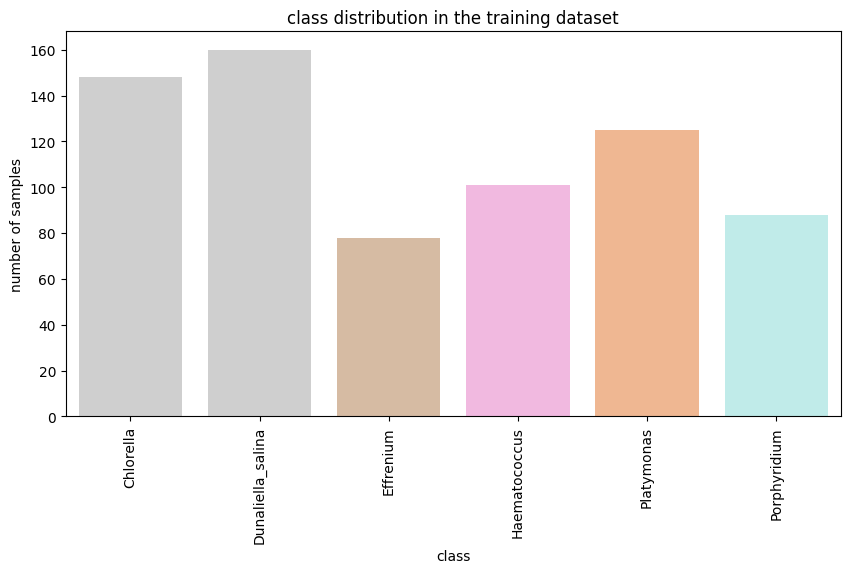

In [3]:
class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

class_distribution = train_generator.classes

class_names_list = [class_names[class_idx] for class_idx in class_distribution]

plt.figure(figsize=(10, 5))
sns.countplot(x=class_names_list, palette='pastel', order=sorted(class_names_list))
plt.title('class distribution in the training dataset')
plt.xlabel('class')
plt.ylabel('number of samples')
plt.xticks(rotation='vertical')
plt.show()

In [4]:
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)

print("class weights")
for class_id, weight in enumerate(class_weights):
    print(f"class- {class_names[class_id]}, weight- {weight}")

class weights
class- Chlorella, weight- 0.7882882882882883
class- Dunaliella_salina, weight- 0.7291666666666666
class- Effrenium, weight- 1.4957264957264957
class- Haematococcus, weight- 1.155115511551155
class- Platymonas, weight- 0.9333333333333333
class- Porphyridium, weight- 1.3257575757575757


In [5]:
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: np.float64(0.7882882882882883),
 1: np.float64(0.7291666666666666),
 2: np.float64(1.4957264957264957),
 3: np.float64(1.155115511551155),
 4: np.float64(0.9333333333333333),
 5: np.float64(1.3257575757575757)}

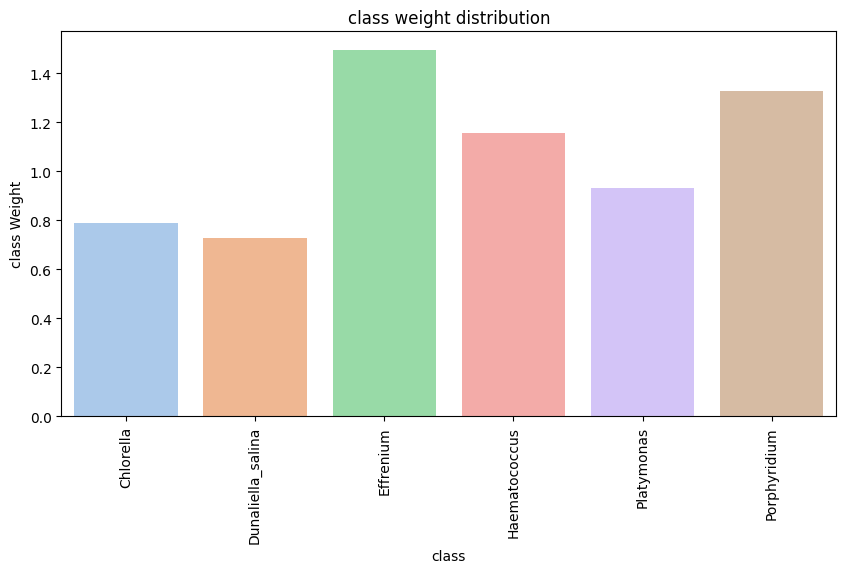

In [6]:
class_weights = [0.78828829, 0.72916667, 1.4957265, 1.15511551, 0.93333333, 1.32575758]
new_class_names = ['Chlorella', 'Dunaliella_salina', 'Effrenium', 'Haematococcus', 'Platymonas', 'Porphyridium']

data = {'Class': new_class_names, 'Weight': class_weights}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Weight', data=df, palette='pastel')
plt.title('class weight distribution')
plt.xlabel('class')
plt.ylabel('class Weight')
plt.xticks(rotation='vertical')
plt.show()

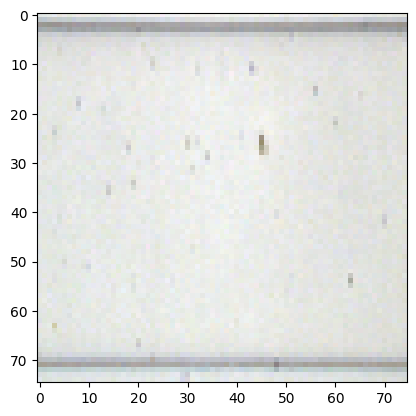

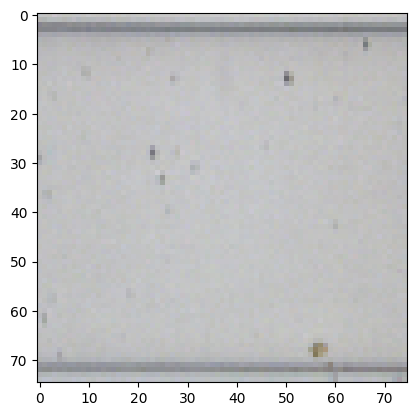

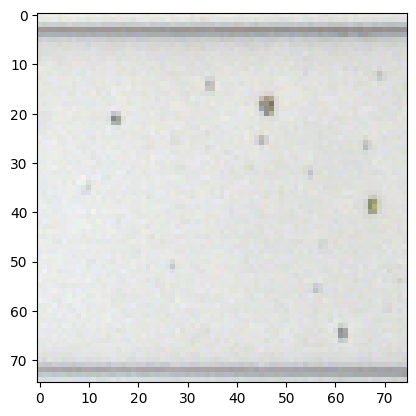

In [7]:
for _ in range(10):
    img, label = next(train_generator)
    if label[0][1] == 1:
        plt.imshow(img[0])
        plt.show()

In [8]:
base_model=InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(75,75,3),
    pooling=None,
    classes=6,
    classifier_activation="softmax",
)

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
InceptionV3_learner=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

In [11]:
InceptionV3_learner.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 1, 1, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,870 (85.18 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [12]:
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), 
]

In [13]:
InceptionV3_learner.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'] + METRICS,
)

In [14]:
InceptionV3_history=InceptionV3_learner.fit(train_generator,epochs=100,class_weight=class_weight_dict)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.1850 - auc: 0.5172 - loss: 2.3063 - prc: 0.1750 - precision: 0.1779 - recall: 0.0488
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.2299 - auc: 0.5835 - loss: 1.8295 - prc: 0.2242 - precision: 0.3425 - recall: 0.0577
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.3062 - auc: 0.6641 - loss: 1.7299 - prc: 0.2869 - precision: 0.4208 - recall: 0.0672
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.3534 - auc: 0.7062 - loss: 1.6194 - prc: 0.3455 - precision: 0.5639 - recall: 0.1158
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3468 - auc: 0.7137 - loss: 1.5862 - prc: 0.3498 - precision: 0.4789 - recall: 0.0940
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.3890 - auc: 0.7630 - loss: 1.4609 - prc: 0.4082 - precision: 0.5188 - recall: 0.1235
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.4018 - auc: 0.7516 - loss: 1.5112 

In [15]:
model_save_path = '../results/inceptionv3_model.h5'
InceptionV3_learner.save(model_save_path)
print(f"model saved to {model_save_path}")

model saved to ../results/inceptionv3_model.h5


In [16]:
history_df = pd.DataFrame(InceptionV3_history.history)
history_csv_path = '../results/inceptionv3_history.csv'
history_df.to_csv(history_csv_path, index=False)
print(f"training history saved to {history_csv_path}")

training history saved to ../results/inceptionv3_history.csv


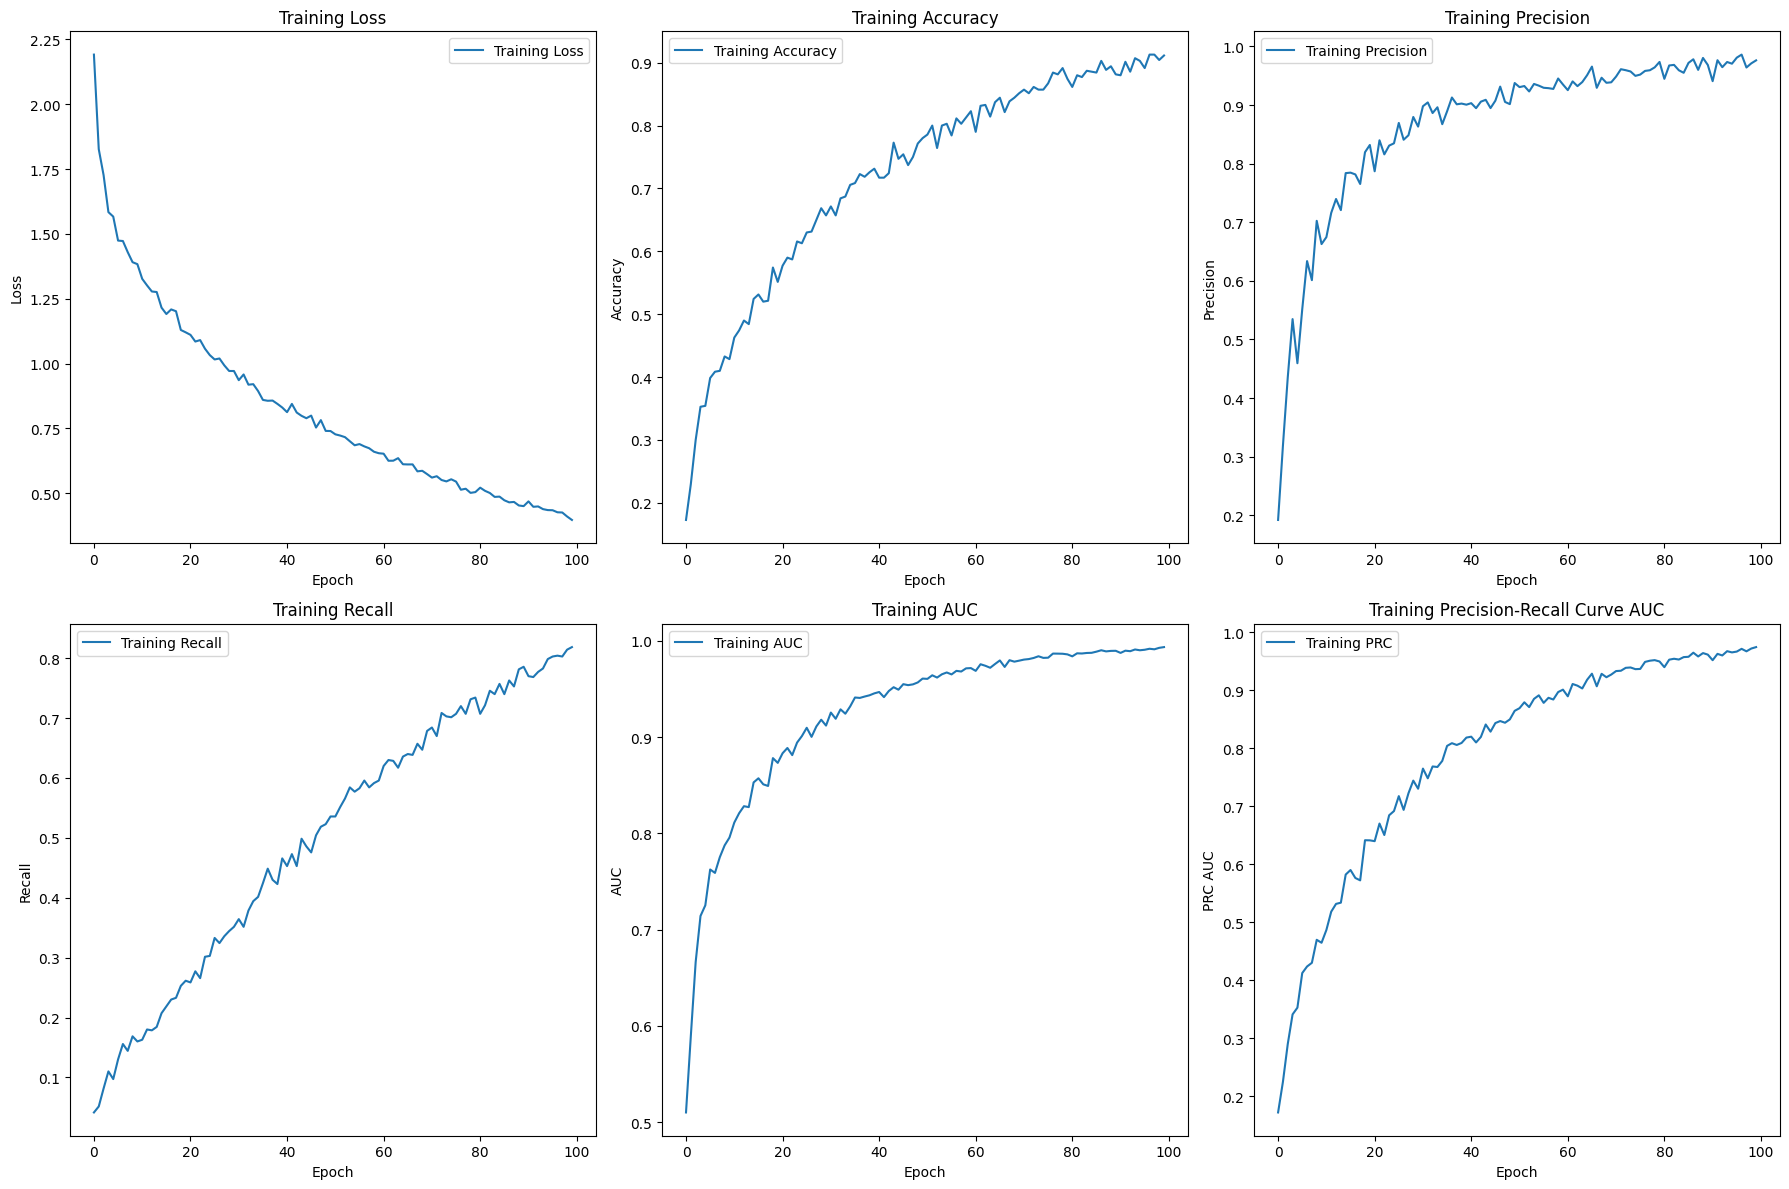

In [17]:
history_csv_path = '../results/inceptionv3_history.csv'

history_df_loaded = pd.read_csv(history_csv_path)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history_df_loaded['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(history_df_loaded['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(history_df_loaded['precision'], label='Training Precision')
plt.title('Training Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(history_df_loaded['recall'], label='Training Recall')
plt.title('Training Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(history_df_loaded['auc'], label='Training AUC')
plt.title('Training AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(history_df_loaded['prc'], label='Training PRC')
plt.title('Training Precision-Recall Curve AUC')
plt.xlabel('Epoch')
plt.ylabel('PRC AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    directory=r"D:\desktop\python\algaenet\dataset\val\images", 
    target_size=(75, 75),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=False, 
    seed=42
)

if validation_generator.num_classes > 0:
    print(f"found {validation_generator.samples} validation images belonging to {validation_generator.num_classes} classes.")
    print(f"validation class indices- {validation_generator.class_indices}")
else:
    print(f"no validation images found.")


Found 138 images belonging to 6 classes.
found 138 validation images belonging to 6 classes.
validation class indices- {'Chlorella': 0, 'Dunaliella_salina': 1, 'Effrenium': 2, 'Haematococcus': 3, 'Platymonas': 4, 'Porphyridium': 5}


In [20]:
from tensorflow.keras.models import load_model

model_load_path = '../results/inceptionv3_model.h5'
loaded_model = load_model(model_load_path)

loaded_model.compile(
    optimizer=Adam(learning_rate=0.00005), 
    loss='categorical_crossentropy',
    metrics=['accuracy'] + METRICS, 
)

epochs_finetune = 20 

test_steps_per_epoch = 5 
test_validation_steps = 2

print(f"number of training samples- {train_generator.samples}")
print(f"number of validation samples- {validation_generator.samples}")
print(f"batch size- {train_generator.batch_size}")
print(f"calculated steps_per_epoch- {train_generator.samples // train_generator.batch_size}")
print(f"calculated validation_steps- {validation_generator.samples // validation_generator.batch_size}")

fine_tune_history = loaded_model.fit(
    train_generator,
    epochs=epochs_finetune,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    steps_per_epoch=test_steps_per_epoch, 
    validation_steps=test_validation_steps  
)

finetuned_model_save_path = '../results/inceptionv3_finetuned_model.h5'
loaded_model.save(finetuned_model_save_path)
print(f"fine-tuned model saved to {finetuned_model_save_path}")

fine_tune_history_df = pd.DataFrame(fine_tune_history.history)
fine_tune_history_csv_path = '../results/inceptionv3_finetune_history.csv'
fine_tune_history_df.to_csv(fine_tune_history_csv_path, index=False)
print(f"fine-tuning history saved to {fine_tune_history_csv_path}")

number of training samples- 700
number of validation samples- 138
batch size- 64
calculated steps_per_epoch- 10
calculated validation_steps- 2
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 235s 23s/step - accuracy: 0.9436 - auc: 0.9940 - loss: 0.3796 - prc: 0.9766 - precision: 0.9790 - recall: 0.8266 - val_accuracy: 0.9141 - val_auc: 0.9895 - val_loss: 0.4213 - val_prc: 0.9712 - val_precision: 0.9730 - val_recall: 0.8438
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.8619 - auc: 0.9886 - loss: 0.4124 - prc: 0.9565 - precision: 0.9345 - recall: 0.7978 - val_accuracy: 0.9219 - val_auc: 0.9911 - val_loss: 0.4020 - val_prc: 0.9762 - val_precision: 0.9907 - val_recall: 0.8359
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9375 - auc: 0.9941 - loss: 0.3815 - prc: 0.9761 - precision: 0.9804 - recall: 0.7812 - val_accuracy: 0.9219 - val_auc: 0.9912 - val_loss: 0.3991 - val_prc: 0.9766 - val_precision: 0.9908 - val_recall: 0.8438
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/st

fine-tuned model saved to ../results/inceptionv3_finetuned_model.h5
fine-tuning history saved to ../results/inceptionv3_finetune_history.csv


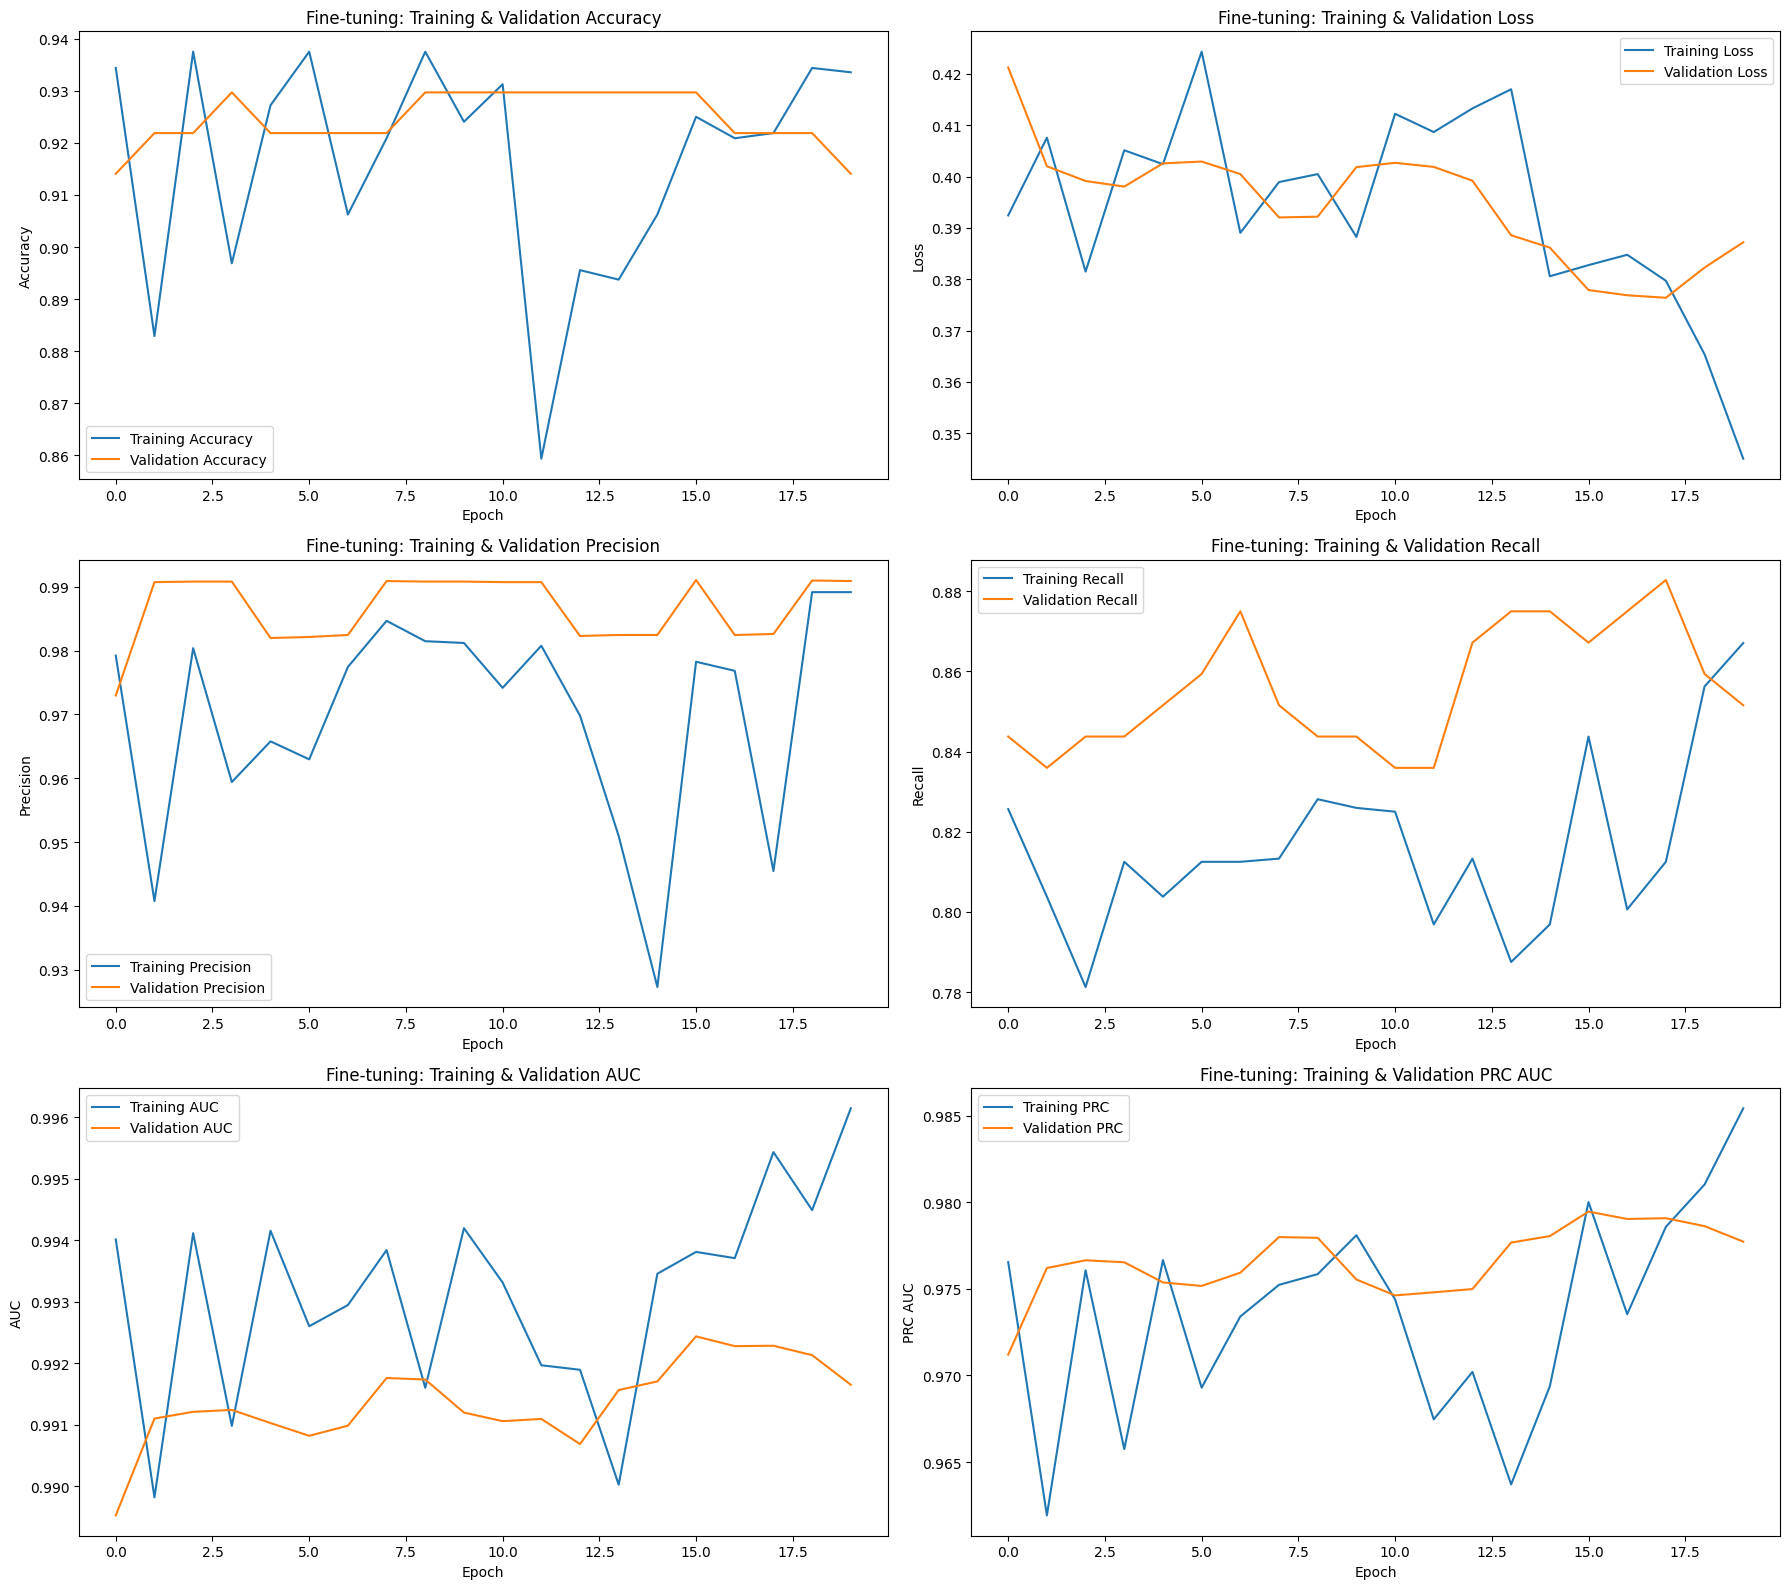

In [21]:
history_df_finetune = pd.read_csv('../results/inceptionv3_finetune_history.csv')

plt.figure(figsize=(18, 16)) 

plt.subplot(3, 2, 1)
plt.plot(history_df_finetune['accuracy'], label='Training Accuracy')
plt.plot(history_df_finetune['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning: Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(history_df_finetune['loss'], label='Training Loss')
plt.plot(history_df_finetune['val_loss'], label='Validation Loss')
plt.title('Fine-tuning: Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

if 'precision' in history_df_finetune.columns and 'val_precision' in history_df_finetune.columns:
    plt.subplot(3, 2, 3)
    plt.plot(history_df_finetune['precision'], label='Training Precision')
    plt.plot(history_df_finetune['val_precision'], label='Validation Precision')
    plt.title('Fine-tuning: Training & Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

if 'recall' in history_df_finetune.columns and 'val_recall' in history_df_finetune.columns:
    plt.subplot(3, 2, 4)
    plt.plot(history_df_finetune['recall'], label='Training Recall')
    plt.plot(history_df_finetune['val_recall'], label='Validation Recall')
    plt.title('Fine-tuning: Training & Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

if 'auc' in history_df_finetune.columns and 'val_auc' in history_df_finetune.columns:
    plt.subplot(3, 2, 5)
    plt.plot(history_df_finetune['auc'], label='Training AUC')
    plt.plot(history_df_finetune['val_auc'], label='Validation AUC')
    plt.title('Fine-tuning: Training & Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

if 'prc' in history_df_finetune.columns and 'val_prc' in history_df_finetune.columns:
    plt.subplot(3, 2, 6)
    plt.plot(history_df_finetune['prc'], label='Training PRC')
    plt.plot(history_df_finetune['val_prc'], label='Validation PRC')
    plt.title('Fine-tuning: Training & Validation PRC AUC')
    plt.xlabel('Epoch')
    plt.ylabel('PRC AUC')
    plt.legend()

plt.tight_layout()
plt.show()

Found 300 images belonging to 1 classes.
found 300 test images to predict.
generator's internal class structure- {'images': 0}


successfully loaded fine-tuned model from ../results/inceptionv3_finetuned_model.h5
warning- train_generator not found. Attempting to use a predefined class mapping.
using predefined class mapping- {0: 'Chlorella', 1: 'Dunaliella_salina', 2: 'Effrenium', 3: 'Haematococcus', 4: 'Platymonas', 5: 'Porphyridium'}.

making predictions on the test set...


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step

first 10 predictions-
file- images\00701.jpg, predicted class- Platymonas
file- images\00702.jpg, predicted class- Haematococcus
file- images\00703.jpg, predicted class- Chlorella
file- images\00704.jpg, predicted class- Platymonas
file- images\00705.jpg, predicted class- Platymonas
file- images\00706.jpg, predicted class- Haematococcus
file- images\00707.jpg, predicted class- Haematococcus
file- images\00708.jpg, predicted class- Dunaliella_salina
file- images\00709.jpg, predicted class- Chlorella
file- images\00710.jpg, predicted class- Haematococcus
Found 300 images belonging to 1 classes.


<Figure size 1500x1000 with 0 Axes>

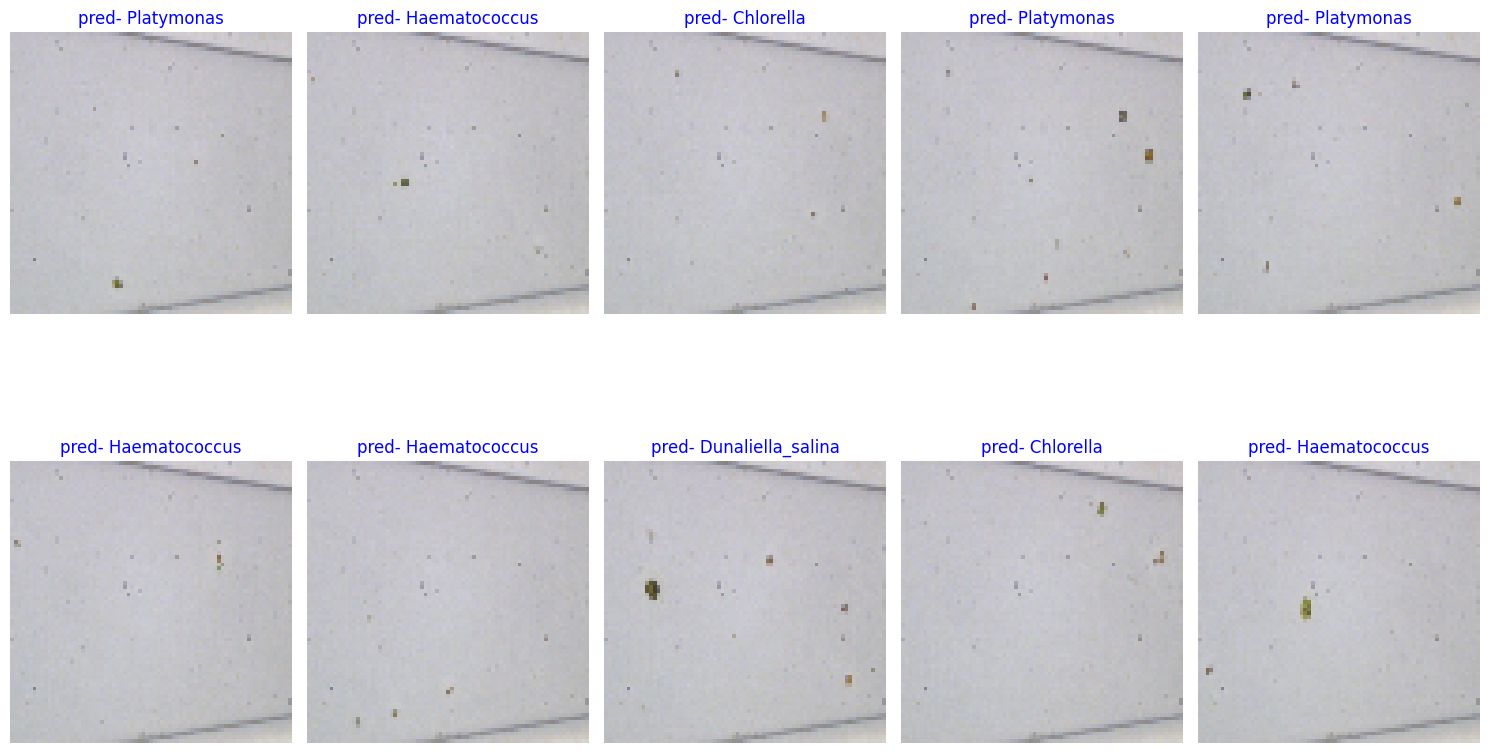

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import math
import os

test_data_base_dir = r"D:\desktop\python\algaenet\dataset\test" 

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_data_base_dir,
    target_size=(75, 75),
    color_mode="rgb",
    batch_size=32, 
    class_mode=None, 
    shuffle=False,    
    seed=42
)

if test_generator.samples == 0:
    print(f"no test images found by the generator. please check the directory path: {test_data_base_dir}")
    print("ensure it contains a subfolder with your test images inside.")
else:
    print(f"found {test_generator.samples} test images to predict.")
    print(f"generator's internal class structure- {test_generator.class_indices}")


finetuned_model_path = '../results/inceptionv3_finetuned_model.h5'
try:
    prediction_model = load_model(finetuned_model_path)
    print(f"successfully loaded fine-tuned model from {finetuned_model_path}")
except Exception as e:
    print(f"error loading the fine-tuned model- {e}")
    raise

if 'train_generator' in locals() or 'train_generator' in globals():
    idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
    print(f"using class mapping from train_generator- {idx_to_class}")
else:
    print("warning- train_generator not found. Attempting to use a predefined class mapping.")
    idx_to_class = {0: 'Chlorella', 1: 'Dunaliella_salina', 2: 'Effrenium', 3: 'Haematococcus', 4: 'Platymonas', 5: 'Porphyridium'}
    print(f"using predefined class mapping- {idx_to_class}.")

if test_generator.samples > 0:
    print("\nmaking predictions on the test set...")
    predictions_probabilities = prediction_model.predict(test_generator, verbose=1)

    predicted_class_indices = np.argmax(predictions_probabilities, axis=1)
    predicted_class_names = [idx_to_class.get(idx, f"unknown_Index_{idx}") for idx in predicted_class_indices]

    test_filenames_from_generator = test_generator.filenames 
    
    print(f"\nfirst 10 predictions-")
    for i in range(min(10, len(test_filenames_from_generator))):
        print(f"file- {test_filenames_from_generator[i]}, predicted class- {predicted_class_names[i]}")

    num_images_to_display = min(10, test_generator.samples)

    test_generator.reset() 

    plt.figure(figsize=(15, 5 * math.ceil(num_images_to_display / 5)))
    for i in range(num_images_to_display):
        img_batch = next(test_generator) 
        img = img_batch[0] 

    display_generator = test_datagen.flow_from_directory(
        directory=test_data_base_dir,
        target_size=(75, 75),
        color_mode="rgb",
        batch_size=1, 
        class_mode=None, 
        shuffle=False,
        seed=42
    )

    plt.figure(figsize=(15, 5 * math.ceil(num_images_to_display / 5)))
    for i in range(num_images_to_display):
        img = next(display_generator) 
        
        plt.subplot(math.ceil(num_images_to_display / 5), 5, i + 1)
        plt.imshow(img[0]) 
        
        plt.title(f"pred- {predicted_class_names[i]}", color='blue')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

else:
    print("skipping prediction as no test images were found by the generator.")
